# Analysis of highly negative pressure areas in CONUS2
- some places have highly negative pressures, so here we look at pressure, saturation, et, forcing for these locations


In [1]:
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.settings import set_working_directory
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

#setting the directory name that we will read our outputs from
run_name = 'PFCLM_SC' 
pf_run_dir = '/glade/scratch/tijerina/CONUS2/scaling_runs/single_column_testing/output_wb'
clm_run_dir = '/glade/scratch/tijerina/CONUS2/scaling_runs/single_column_testing/output_wb'


# run_name = 'mod_pressure' 
# pf_run_dir = '/glade/scratch/tijerina/CONUS2/scaling_runs/modified_pressure_run/output-pf'
# clm_run_dir = '/glade/scratch/tijerina/CONUS2/scaling_runs/modified_pressure_run/output-clm'


# run_name = 'spinup.wy2003' #'spinup.scaling.48_36' # 'spinup.scaling.9.70_54'#
# pf_run_dir = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs/output-pf' #spinup_scaling/outputs_r1_0-25_4' #copy_spinup_scaling' #
# clm_run_dir = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs/output-clm'
print(pf_run_dir)
print(clm_run_dir)

/glade/scratch/tijerina/CONUS2/scaling_runs/single_column_testing/output_wb
/glade/scratch/tijerina/CONUS2/scaling_runs/single_column_testing/output_wb


####  Read in the domain properties

In [4]:
run = Run.from_definition(f'{pf_run_dir}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz)

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
#mannings = pf.read_pfb(f'{run_dir}/spinup.scaling.48_36.out.n.pfb') #run.Mannings.Geom.domain.Value
#mannings = data.mannings

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
## this fixes a windows issue
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

#slopex = data.slope_x 
#slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
# check with mask that has 0 and 1
nanmask=mask.copy()
#nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

  - qflx_tran_vegm
25 1 1 20 2.0 2.0 [1.   0.5  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.01]


In [5]:
nt

25

#### Read the simulation output files

In [6]:
#list all pressure files from outputs
lw_press_files = glob(f'{pf_run_dir}/{run_name}.out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(lw_press_files) * nanmask

#list all saturation files from outputs
lw_satur_files = glob(f'{pf_run_dir}/{run_name}.out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(lw_satur_files) * nanmask

In [7]:
pressure_arrays.shape

(25, 20, 1, 1)

In [8]:
len(lw_press_files)
clm_counter = len(lw_press_files)-2
clm_counter

23

### Find indices of pressures that are negative, plot timeseries

In [9]:
# Single Pressure file to find indices with very negative pressures 
single_pressure = pf.read_pfb(f'{pf_run_dir}/{run_name}.out.press.00024.pfb')*nanmask

In [10]:
single_press_top = single_pressure[9,...]
print(single_press_top.max())
print(single_press_top.min())

-4.328001490647562
-4.328001490647562


In [11]:
# Find indices of pressure top layer that are super negative
negative_array = np.argwhere(single_press_top < -2000)
negative_array#[0:15,:] #print some indices
y_index = negative_array[:,0]
x_index = negative_array[:,1]
y_index

array([ 468,  468,  468,  468,  469,  469,  469,  469,  470,  470,  470,
        471,  471,  471,  471,  472,  472,  472,  472,  472,  472,  472,
        473,  473,  473,  473,  473,  473,  474,  474,  474,  474,  474,
        475,  475,  475,  475,  476,  476,  476,  476,  476,  477,  477,
        477,  477,  477,  477,  478,  478,  478,  478,  478,  479,  479,
        479,  479,  479,  479,  480,  480,  480,  480,  480,  480,  481,
        481,  481,  481,  481,  482,  482,  482,  482,  482,  483,  483,
        483,  483,  484,  484,  484,  485,  485,  485,  486,  486,  486,
        487,  487,  487,  487,  488,  488,  488,  488, 1006, 1006, 1006,
       1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1024, 1024, 1025,
       1025, 1026, 1026, 1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027,
       1027, 1027, 1027, 1027, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
       1028, 1029, 1029, 1029, 1029, 1029, 1030, 1030, 1034, 1059, 1059,
       1059, 1059, 1059, 1060, 1060, 1060, 1060, 10

In [12]:
# Save plots for pressure at each negative index
### THIS IS COMMENTED OUT TO HIDE THE OUTPUT PLOTS (there are a lot)

# for i in range(len(negative_array)):
#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.plot(pressure_arrays[0:86,9,y_index[i],x_index[i]])
#     ax.set_ylabel('pressure [m]')
#     plt.xlabel('Simulated Hours')
#     plt.title(f'pressure_{negative_array[i]}')
#     plt.savefig(f'negative_pressure_plots/pressure_{negative_array[i]}.png')
    


### Make timeseries plots of saturation at areas with very negative pressures

In [13]:
# saturation for the top 4 layers
### THIS IS COMMENTED OUT TO HIDE THE OUTPUT PLOTS (there are a lot)

# for i in range(len(negative_array)):
#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.plot(saturation_arrays[0:86,9,y_index[i],x_index[i]], label = 'Top (10)')
#     ax.plot(saturation_arrays[0:86,8,y_index[i],x_index[i]], label = '(9)')
#     ax.plot(saturation_arrays[0:86,7,y_index[i],x_index[i]], label = '(8)')
#     ax.plot(saturation_arrays[0:86,6,y_index[i],x_index[i]], label = '(7)')
#     # ax.plot(saturation_arrays[0:86,5,y_index[i],x_index[i]], label = '(6)')
#     # ax.plot(saturation_arrays[0:86,4,y_index[i],x_index[i]], label = '(5)')
#     # ax.plot(saturation_arrays[0:86,3,y_index[i],x_index[i]], label = '(4)')
#     # ax.plot(saturation_arrays[0:86,2,y_index[i],x_index[i]], label = '(3)')
#     # ax.plot(saturation_arrays[0:86,1,y_index[i],x_index[i]], label = '(2)')
#     #ax.plot(saturation_arrays[0:86,0,y_index[i],x_index[i]], label = 'Bottom (1)')
#     ax.set_ylabel('saturation []')
#     #ax.invert_yaxis()
#     plt.xlabel('Simulated Hours')
#     plt.legend()
#     plt.title(f'top 4 layers, saturation_{negative_array[i]}')
#     plt.savefig(f'negative_pressure_plots/saturation_{negative_array[i]}.png')
# saturation_arrays[0:86,9,y_index[7],x_index[7]]

In [16]:
top_layer_sat_arrays.shape

(87, 3256, 4442)

In [31]:
# mean top layer saturation
top_layer_sat_arrays = saturation_arrays[:,9,:,:]
# mean soil moisture (top layer) for the 3+ days
mean_soil_moisture = np.mean(top_layer_sat_arrays[0:71,...], axis = 0)

### Find slopes at locations with very negative pressures

In [14]:
### set up pandas data fram of nx & ny for negative pressure cells, slopes 
press_slopes = pd.DataFrame(columns = ['y_neg_index', 'x_neg_index', 'y_slope', 'x_slope'])
press_slopes['y_neg_index'] = y_index
press_slopes['x_neg_index'] = x_index
for i in range(len(negative_array)):
    press_slopes['y_slope'][i] = slopey[0,y_index[i],x_index[i]]
    press_slopes['x_slope'][i] = slopex[0,y_index[i],x_index[i]]

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [38]:
press_slopes

,y_neg_index,x_neg_index,y_slope,x_slope
0,468,3608,0.000762,0.006506
1,468,3609,-0.00069,-0.007326
2,468,3610,0.000372,-0.003291
3,468,3611,0.000215,-0.001958
4,469,3608,-0.006897,0.005053
...,...,...,...,...
335,2052,4123,0.005684,-0.000627
336,2053,4123,0.00251,-0.004103
337,2212,4322,0.004453,0.000516
338,2212,4323,0.002087,-0.000914


In [39]:
press_slopes.to_csv('negative_pressure_plots/slopes_at_negative_pressures_CONUS2.csv', sep = ",")

### Calculate ET and make plots at locations with very negative pressures

In [29]:
set_working_directory(clm_run_dir)

In [19]:
# 4: qflx_evap_tot for total evaporation [mm/s]
qflx_evap_CLM = np.zeros((86, ny, nx))
for i in range(clm_counter):    
    print(f'reading file {i}')
    CLM_file = pf.read_pfb(f'{clm_run_dir}/{run_name}.out.clm_output.{str(i+1).zfill(5)}.C.pfb')
    CLM_file[CLM_file<-9000] = 0 # set values outside of the domain to zero
    qflx_evap_CLM[i, ...] = CLM_file[4,...] # fill qflx_evap_CLM array by flagging the 4 position in the CLM file for qflx_evap_tot

reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
reading file 8
reading file 9
reading file 10
reading file 11
reading file 12
reading file 13
reading file 14
reading file 15
reading file 16
reading file 17
reading file 18
reading file 19
reading file 20
reading file 21
reading file 22
reading file 23
reading file 24
reading file 25
reading file 26
reading file 27
reading file 28
reading file 29
reading file 30
reading file 31
reading file 32
reading file 33
reading file 34
reading file 35
reading file 36
reading file 37
reading file 38
reading file 39
reading file 40
reading file 41
reading file 42
reading file 43
reading file 44
reading file 45
reading file 46
reading file 47
reading file 48
reading file 49
reading file 50
reading file 51
reading file 52
reading file 53
reading file 54
reading file 55
reading file 56
reading file 57
reading file 58
reading file 59
reading file 60
reading file 61
reading file 62
re

(86, 3256, 4442)


Text(0.5, 1.0, 'net veg. evaporation and transpiration and soil evaporation (mmh-1) for hour 1')

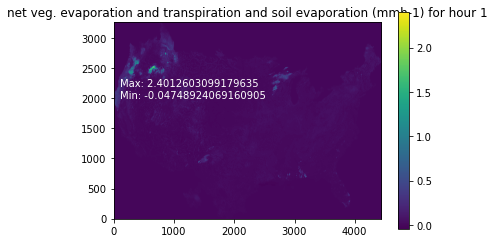

In [21]:
# convert ET from mm/s to mm/h
qflx_evap_CLM = qflx_evap_CLM*3600

# checking evap flux values and make sure that loop worked
# Plot of full CONUS, one timestep
print(qflx_evap_CLM.shape)
t = 0 #select timestep (hour) to plot
plt.imshow(qflx_evap_CLM[t,...], origin="lower")
plt.colorbar()
plt.annotate(f'Max: {qflx_evap_CLM[t].max()}', xy = (100,2200), color = 'white')
plt.annotate(f'Min: {qflx_evap_CLM[t].min()}', xy = (100,2000), color = 'white')
plt.title(f'net veg. evaporation and transpiration and soil evaporation (mmh-1) for hour {t+1}')

In [17]:
# Timeseries of ET where we have super negative pressures 
### THIS IS COMMENTED OUT TO HIDE THE OUTPUT PLOTS (there are a lot)
# for i in range(len(negative_array)):
#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.plot(qflx_evap_CLM[0:85,y_index[i],x_index[i]])
#     ax.set_ylabel('et (qflx_evap_tot) [mm/h]')
#     plt.xlabel('Simulated Hours')
#     plt.title(f'et_{negative_array[i]}')
#     plt.savefig(f'negative_pressure_plots/et_{negative_array[i]}.png', bbox_inches="tight")

In [29]:
qflx_evap_CLM.shape

(86, 3256, 4442)

In [30]:
# mean ET for the 3+ days
mean_soil_evap = np.mean(qflx_evap_CLM[0:71,...], axis = 0)

#### Subplots with pressure, sat, et at negative pressure locations

In [1]:
# Make subplots combining the previous plots of pressure, saturation, and ET
### THIS IS COMMENTED OUT TO HIDE THE OUTPUT PLOTS (there are a lot)

# for i in range(len(negative_array)):
#     fig, ax = plt.subplots(3,1,figsize=(6,8))
#     fig.tight_layout(h_pad=2)
#     ax[0].plot(pressure_arrays[0:86,9,y_index[i],x_index[i]])
#     ax[0].set_title(f'pressure {negative_array[i]}')
#     ax[0].set_ylabel('press [m]')
#     ax[1].plot(saturation_arrays[0:86,9,y_index[i],x_index[i]], label = 'Top (10)')
#     ax[1].plot(saturation_arrays[0:86,8,y_index[i],x_index[i]], label = '(9)')
#     ax[1].plot(saturation_arrays[0:86,7,y_index[i],x_index[i]], label = '(8)')
#     ax[1].plot(saturation_arrays[0:86,6,y_index[i],x_index[i]], label = '(7)')
#     ax[1].set_title(f'top 4 layers, saturation {negative_array[i]}')
#     ax[1].set_ylabel('sat []')
#     ax[1].legend()
#     ax[2].plot(qflx_evap_CLM[0:85,y_index[i],x_index[i]])
#     ax[2].set_ylabel('et [m]')
#     ax[2].set_title(f'et (qflx_evap_tot) {negative_array[i]}')
#     ax[2].set_xlabel('Simulated Hours')
#     #plt.savefig(f'negative_pressure_plots/subplots/subplots_ET-press-sat_{negative_array[i]}.png',bbox_inches="tight")

### Bare soil and transpiration plots

In [ ]:
# 6:  soil evaporation (mms-1) 
soil_evap_CLM = np.zeros((86, ny, nx))
for i in range(clm_counter):    
    print(f'reading file {i}')
    CLM_file = pf.read_pfb(f'{clm_run_dir}/{run_name}.out.clm_output.{str(i+1).zfill(5)}.C.pfb')
    CLM_file[CLM_file<-9000] = 0 # set values outside of the domain to zero
    soil_evap_CLM[i, ...] = CLM_file[6,...] # fill soil_evap_CLM array by flagging the 6 position in the CLM file for soil_evap_tot

(86, 3256, 4442)


Text(0.5, 1.0, 'bare soil evaporation (mmh-1) for hour 1')

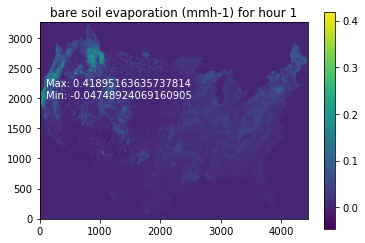

In [26]:
# convert bare soil ET from mm/s to mm/h
soil_evap_CLM = soil_evap_CLM*3600

# checking evap flux values and make sure that loop worked
# Plot of full CONUS, one timestep
print(soil_evap_CLM.shape)
t = 0 #select timestep (hour) to plot
plt.imshow(soil_evap_CLM[t,...], origin="lower")
plt.colorbar()
plt.annotate(f'Max: {soil_evap_CLM[t].max()}', xy = (100,2200), color = 'white')
plt.annotate(f'Min: {soil_evap_CLM[t].min()}', xy = (100,2000), color = 'white')
plt.title(f'bare soil evaporation (mmh-1) for hour {t+1}')

In [ ]:
# Timeseries of ET where we have super negative pressures 
### THIS IS COMMENTED OUT TO HIDE THE OUTPUT PLOTS (there are a lot)
for i in range(len(negative_array)):
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(soil_evap_CLM[0:85,y_index[i],x_index[i]])
    ax.set_ylabel('Bare Soil ET [mm/h]')
    plt.xlabel('Simulated Hours')
    plt.title(f'Bare Soil {negative_array[i]}')
    plt.savefig(f'negative_pressure_plots/bare_soil_{negative_array[i]}.png', bbox_inches="tight")

In [ ]:
#####################################################
# 8:  transpiration (mms-1) 
transpiration_CLM = np.zeros((86, ny, nx))
for i in range(clm_counter):    
    print(f'reading file {i}')
    CLM_file = pf.read_pfb(f'{clm_run_dir}/{run_name}.out.clm_output.{str(i+1).zfill(5)}.C.pfb')
    CLM_file[CLM_file<-9000] = 0 # set values outside of the domain to zero
    transpiration_CLM[i, ...] = CLM_file[8,...] # fill transpiration_CLM array by flagging the 8 position in the CLM file for transpiration

(86, 3256, 4442)


Text(0.5, 1.0, 'transpiration (mmh-1) for hour 13')

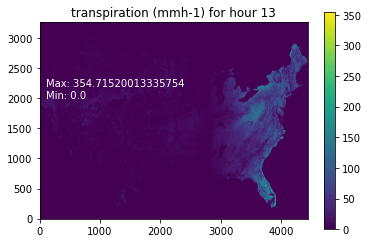

In [31]:
# convert ET from mm/s to mm/h
transpiration_CLM = transpiration_CLM*3600

# checking evap flux values and make sure that loop worked
# Plot of full CONUS, one timestep
print(transpiration_CLM.shape)
t = 12 #select timestep (hour) to plot
plt.imshow(transpiration_CLM[t,...], origin="lower")
plt.colorbar()
plt.annotate(f'Max: {transpiration_CLM[t].max()}', xy = (100,2200), color = 'white')
plt.annotate(f'Min: {transpiration_CLM[t].min()}', xy = (100,2000), color = 'white')
plt.title(f'transpiration (mmh-1) for hour {t+1}')

In [37]:
transpir_df = pd.DataFrame(columns = ['tran_at_index'])
transpir_df['tran_at_index'] = transpiration_CLM[:,2212,4323]
transpir_df

,tran_at_index
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
81,0.0
82,0.0
83,0.0
84,0.0


In [ ]:
# # Timeseries of transpiration where we have super negative pressures 
# ### THIS IS COMMENTED OUT TO HIDE THE OUTPUT PLOTS (there are a lot)
# for i in range(len(negative_array)):
#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.plot(transpiration_CLM[0:85,y_index[i],x_index[i]])
#     ax.set_ylabel('transpiration [mm/h]')
#     plt.xlabel('Simulated Hours')
#     plt.title(f'transpiration {negative_array[i]}')
#     plt.savefig(f'negative_pressure_plots/transpiration_{negative_array[i]}.png', bbox_inches="tight")

### Find cells for saturation and ET where SM<0.2 and ET>0

In [21]:
# read single saturation
single_saturation = pf.read_pfb(f'{pf_run_dir}/{run_name}.out.satur.00035.pfb')*nanmask
# grab only the top layer of saturation 
single_sat_top = single_saturation[9,...]
print(single_sat_top.max())
print(single_sat_top.min())

1.0
-0.0


In [23]:
single_sat_top[2000:2003,2000:2003]

array([[0.76330274, 0.1225706 , 0.11264598],
       [0.11372343, 0.11382402, 0.11257147],
       [0.12233943, 0.11317266, 0.11271658]])

In [38]:
# ET
single_CLM = pf.read_pfb(f'{clm_run_dir}/{run_name}.out.clm_output.00035.C.pfb')
single_CLM[single_CLM<-9000] = 0 # set values outside of the domain to zero
single_CLM.min()
single_qflx_CLM = single_CLM[4,...] # fill qflx_evap_CLM array by flagging the 4 position in the CLM file for qflx_evap_tot
single_qflx_CLM = single_qflx_CLM*3600 # ET IS IN mm/h
print(single_qflx_CLM.max())
print(single_qflx_CLM.min())

0.8180163365365788
-0.05761551004272887


In [23]:
print(mean_soil_evap.shape)
mean_soil_moisture.shape

(3256, 4442)


(3256, 4442)

In [32]:
### I FIRST DID THIS WITH A SINGLE HOURLY FILE (single_qflx_CLM, single_sat_top), BUT TAKING THE MEAN OF THE 3+ DAYS OF OUTPUTS I HAVE 
### MAKES MORE SENSE, SO THAT IS WHAT IS BELOW.
# Find indices of pressure top layer that are super negative
#et_sat_array = np.argwhere((single_sat_top < 0.2) & (single_qflx_CLM > 0)) #OLD, SINGLE HOUR

et_sat_array = np.argwhere((mean_soil_moisture < 0.2) & (mean_soil_evap > 0))
et_sat_index_y = et_sat_array[:,0]
et_sat_index_x = et_sat_array[:,1]
print(et_sat_array[0:15,:]) #print some indices
et_sat_array.shape

[[  47 1807]
 [  50 1725]
 [  50 1726]
 [  50 1727]
 [  51 1722]
 [  51 1724]
 [  51 1725]
 [  51 1726]
 [  51 1727]
 [  52 1718]
 [  52 1719]
 [  52 1720]
 [  52 1721]
 [  52 1722]
 [  52 1723]]


(932368, 2)

In [ ]:
et_sat_df = pd.DataFrame(columns = ['ny', 'nx', 'mean ET [mm/h]', 'mean Sat []'])
et_sat_df['ny'] = et_sat_index_y
et_sat_df['nx'] = et_sat_index_x
for i in range(len(et_sat_array[:,0])):
    et_sat_df['mean ET [mm/h]'].loc[i] = mean_soil_evap[et_sat_index_y[i], et_sat_index_x[i]]
    et_sat_df['mean Sat []'].loc[i] = mean_soil_moisture[et_sat_index_y[i], et_sat_index_x[i]]
et_sat_df

In [ ]:
et_sat_df.to_csv('negative_pressure_plots/Sat_less_0.2_ET_more_0-3dayAverage.csv', sep = ",")

In [ ]:
len(et_sat_array[:,0])